In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import re

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/CIS_530_PROJECT/data'
df_train = pd.read_csv(f'{path}/train.csv')
df_val = pd.read_csv(f'{path}/val.csv')
df_test = pd.read_csv(f'{path}/test.csv')

In [4]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}

In [5]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

In [6]:
stopword_list=STOP_WORDS
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']
for word in potential_stopwords:
    stopword_list.add(word)

In [7]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  text = re.sub('https?://[A-Za-z0-9./]+'," ",text)
  text = re.sub("[^a-zA-Z]", " ", text)
  return text 


df_train['comment_text']=df_train['comment_text'].apply(lambda x: clean_text(x))
df_test['comment_text']=df_test['comment_text'].apply(lambda x: clean_text(x))
df_val['comment_text']=df_val['comment_text'].apply(lambda x: clean_text(x))

def replace_invalid_chars(data):
  cleaning = np.vectorize(clean)
  return cleaning(data['comment_text'])

KeyboardInterrupt: ignored

In [ ]:
'''df_train['comment_text'] = replace_invalid_chars(df_train)
df_val['comment_text'] = replace_invalid_chars(df_val)
df_test['comment_text'] = replace_invalid_chars(df_test)'''

In [ ]:
df_train.drop(['Unnamed: 0'], axis = 1, inplace=True)
df_val.drop(['Unnamed: 0'], axis = 1, inplace=True)
df_test.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [ ]:
df_train.drop(df_train[(df_train['toxic'] == -1) | (df_train['severe_toxic'] == -1) | (df_train['obscene'] ==-1) | (df_train['threat'] == -1) | (df_train['insult'] == -1) | (df_train['identity_hate'] == -1)].index, inplace = True)

In [ ]:
df_val.drop(df_val[(df_val['toxic'] == -1) | (df_val['severe_toxic'] == -1) | (df_val['obscene'] ==-1) | (df_val['threat'] == -1) | (df_val['insult'] == -1) | (df_val['identity_hate'] == -1)].index, inplace = True)

In [ ]:
df_test.drop(df_test[(df_test['toxic'] == -1) | (df_test['severe_toxic'] == -1) | (df_test['obscene'] ==-1) | (df_test['threat'] == -1) | (df_test['insult'] == -1) | (df_test['identity_hate'] == -1)].index, inplace = True)

In [ ]:
df_train.head()

In [ ]:
df_val.head()

In [ ]:
df_test.head()

In [ ]:
lens = df_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

In [ ]:
print("Number of missing values in training set - ",df_train['comment_text'].isna().sum())
print("Number of missing values in validation set - ",df_val['comment_text'].isna().sum())
print("Number of missing values in testing set - ",df_test['comment_text'].isna().sum())

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
df_train_text = df_train['comment_text']
df_val_text = df_val['comment_text']
df_test_text = df_test['comment_text']
#df_full_text = pd.concat([df_train_text, df_test_text])

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)

word_vectorizer.fit(df_train_text)

In [ ]:
train_features = word_vectorizer.transform(df_train_text)
val_features = word_vectorizer.transform(df_val_text)
test_features = word_vectorizer.transform(df_test_text)

In [ ]:
scores = []
val_output = pd.DataFrame.from_dict({'id': df_val['id']})
test_output = pd.DataFrame.from_dict({'id': df_test['id']})
for label in labels:
    train_target = df_train[label]
    clf = LogisticRegression(C=0.1, solver='sag')
    cv_score = np.mean(cross_val_score(clf, train_features, train_target, cv=3))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(label, cv_score))

    clf.fit(train_features, train_target)
    #output[label] = clf.predict_proba(val_features)[:, 1]
    val_output[label] = clf.predict(val_features)
    test_output[label] = clf.predict(test_features)
print('Total CV score is {}'.format(np.mean(scores)))

In [ ]:
val_output.head()

In [ ]:
test_output.head()

In [ ]:
val_output.to_csv('val_output.csv',index=False)

In [ ]:
test_output.to_csv('test_output.csv',index=False)

In [ ]:
from sklearn.metrics import f1_score
print("For validation data -")
for label in labels:
  fs_val = f1_score(val_output[label], df_val[label])
  print("f1_score of label",label,"is: ",fs_val)
print("For test data -")
for label in labels:
  fs_test = f1_score(test_output[label], df_test[label])
  print("f1_score of label",label,"is: ",fs_test)

For validation data -
f1_score of label toxic is:  0.6188426590148255
f1_score of label severe_toxic is:  0.1
f1_score of label obscene is:  0.6243654822335026
f1_score of label threat is:  0.0
f1_score of label insult is:  0.5120307988450433
f1_score of label identity_hate is:  0.15568862275449102
For test data -
f1_score of label toxic is:  0.6253776435045317
f1_score of label severe_toxic is:  0.16393442622950818
f1_score of label obscene is:  0.6422338568935427
f1_score of label threat is:  0.04166666666666667
f1_score of label insult is:  0.5356125356125357
f1_score of label identity_hate is:  0.17441860465116282


In [ ]:
from sklearn.metrics import confusion_matrix
print("For validation data -")
for label in labels:
  cm_val = confusion_matrix(df_val[label], val_output[label])
  print(label,'\n',cm_val)
print("For test data -")
for label in labels:
  
  cm_test = confusion_matrix(df_test[label], test_output[label])
  print(label, '\n', cm_test)

For validation data -
toxic 
 [[11731   149]
 [  648   647]]
severe_toxic 
 [[13080    16]
 [   74     5]]
obscene 
 [[12362    49]
 [  395   369]]
threat 
 [[13136     0]
 [   39     0]]
insult 
 [[12402    56]
 [  451   266]]
identity_hate 
 [[13021    12]
 [  129    13]]
For test data -
toxic 
 [[11544   165]
 [  579   621]]
severe_toxic 
 [[12797    31]
 [   71    10]]
obscene 
 [[12131    45]
 [  365   368]]
threat 
 [[12862     0]
 [   46     1]]
insult 
 [[12138    74]
 [  415   282]]
identity_hate 
 [[12752     9]
 [  133    15]]


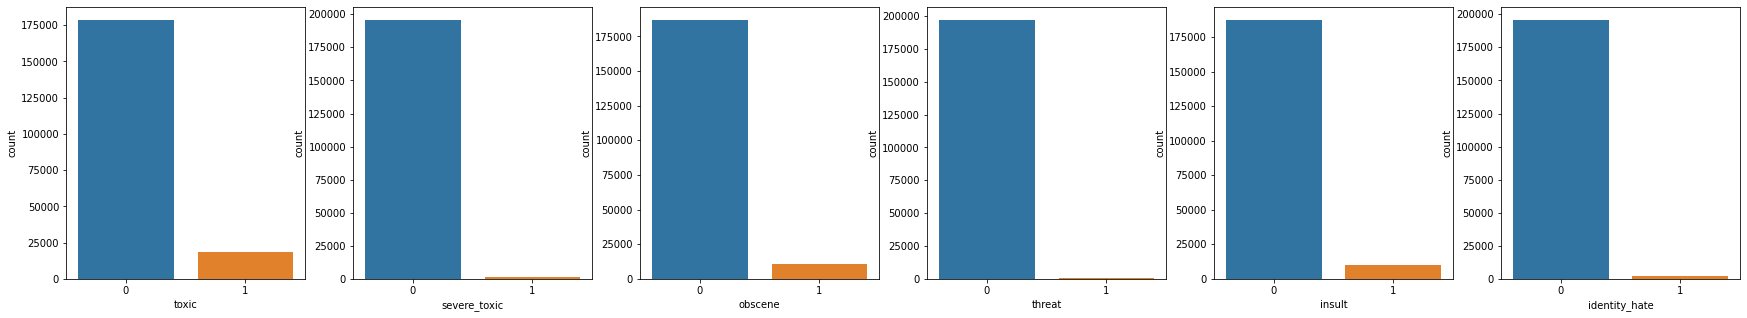

In [ ]:
ncols = len(labels)
fig, axes = plt.subplots(1, ncols, figsize = (30,5))
for label, ax in zip(labels, axes.flatten()):
  axes[0] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)
  axes[1] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)
  axes[2] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)
  axes[3] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)
  axes[4] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)
  axes[5] = sns.countplot(x = label, data=df_train, orient = 'v', ax=ax)


In [ ]:
'''
class_weights = []
toxic_weight = 1/np.sum(df_train['toxic']==1)
severe_toxic_weight = 1/np.sum(df_train['severe_toxic']==1)
obscene_weight = 1/np.sum(df_train['obscene']==1)
threat_weight = 1/np.sum(df_train['threat']==1)
insult_weight = 1/np.sum(df_train['insult']==1)
identity_hate_weight = 1/np.sum(df_train['identity_hate']==1)
class_weights.append(toxic_weight)
class_weights.append(severe_toxic_weight)
class_weights.append(obscene_weight)
class_weights.append(threat_weight)
class_weights.append(insult_weight)
class_weights.append(identity_hate_weight)
print(class_weights)
'''

"\nclass_weights = []\ntoxic_weight = 1/np.sum(df_train['toxic']==1)\nsevere_toxic_weight = 1/np.sum(df_train['severe_toxic']==1)\nobscene_weight = 1/np.sum(df_train['obscene']==1)\nthreat_weight = 1/np.sum(df_train['threat']==1)\ninsult_weight = 1/np.sum(df_train['insult']==1)\nidentity_hate_weight = 1/np.sum(df_train['identity_hate']==1)\nclass_weights.append(toxic_weight)\nclass_weights.append(severe_toxic_weight)\nclass_weights.append(obscene_weight)\nclass_weights.append(threat_weight)\nclass_weights.append(insult_weight)\nclass_weights.append(identity_hate_weight)\nprint(class_weights)\n"

In [ ]:
'''
for index, row in df_train.iterrows():
  row['toxic'] = row['toxic']*class_weights[0]
  row['severe_toxic'] = row['severe_toxic']*class_weights[1]
  row['obscene'] = row['obscene']*class_weights[2]
  row['threat'] = row['threat']*class_weights[3]
  row['insult'] = row['insult']*class_weights[4]
  row['identity_hate'] = row['identity_hate']*class_weights[5]
'''

"\nfor index, row in df_train.iterrows():\n  row['toxic'] = row['toxic']*class_weights[0]\n  row['severe_toxic'] = row['severe_toxic']*class_weights[1]\n  row['obscene'] = row['obscene']*class_weights[2]\n  row['threat'] = row['threat']*class_weights[3]\n  row['insult'] = row['insult']*class_weights[4]\n  row['identity_hate'] = row['identity_hate']*class_weights[5]\n"

In [ ]:
df_train.head()
binary_label = []
for index, row in df_train.iterrows():
  if row['toxic'] ==0 and row['severe_toxic'] ==0 and row['obscene'] ==0 and row['threat'] ==0 and row['insult'] ==0 and row['identity_hate'] ==0:
    binary_label.append(0)
  else:
    binary_label.append(1)
df_train['BinaryLabel'] = binary_label

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,BinaryLabel
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


In [ ]:
sns.countplot(x = 'BinaryLabel', data=df_train)

In [ ]:
data = {'id': df_train['id'], 'comment_text': df_train['comment_text'], 'BinaryLabel': df_train['BinaryLabel']}
df_train_binary = pd.DataFrame(data)
df_train_binary.head()

,id,comment_text,BinaryLabel
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0


In [ ]:
df_val.head()
binary_label = []
for index, row in df_val.iterrows():
  if row['toxic'] ==0 and row['severe_toxic'] ==0 and row['obscene'] ==0 and row['threat'] ==0 and row['insult'] ==0 and row['identity_hate'] ==0:
    binary_label.append(0)
  else:
    binary_label.append(1)
df_val['BinaryLabel'] = binary_label

In [ ]:
df_val.head()

In [ ]:
sns.countplot(x = 'BinaryLabel', data=df_val)

In [ ]:
data = {'id': df_val['id'], 'comment_text': df_val['comment_text'], 'BinaryLabel': df_val['BinaryLabel']}
df_val_binary = pd.DataFrame(data)
df_val_binary.head()

,id,comment_text,BinaryLabel
0,9713018204749040,bhartm art visi dirt com nine twenty oh five,0
1,9714843a344867d5,hi guys it is supposed to be an early history...,0
2,9714fd5ca63b15e3,is the columbian cyclopedia of still consider...,0
3,97177c732d93ee54,youre not even muslim what do you know of anyt...,0
4,9719142aa2eba4d8,hey maybe i should go to the mohandas gandhi ...,0


In [ ]:
df_test.head()
binary_label = []
for index, row in df_test.iterrows():
  if row['toxic'] ==0 and row['severe_toxic'] ==0 and row['obscene'] ==0 and row['threat'] ==0 and row['insult'] ==0 and row['identity_hate'] ==0:
    binary_label.append(0)
  else:
    binary_label.append(1)
df_test['BinaryLabel'] = binary_label

In [ ]:
df_test.head()

In [ ]:
sns.countplot(x = 'BinaryLabel', data=df_test)

In [ ]:
data = {'id': df_test['id'], 'comment_text': df_test['comment_text'], 'BinaryLabel': df_test['BinaryLabel']}
df_test_binary = pd.DataFrame(data)
df_test_binary.head()

,id,comment_text,BinaryLabel
0,cb92363bb7c19368,actually it claims that there is a day photom...,0
1,cb9287e7451d6372,width style background transparent width styl...,0
2,cb9317f2cd4dd6a5,types of clitoris and vulva http w the clitori...,0
3,cb941470e3f85fb2,a sketch of a proposal i have the beginnings ...,0
4,cb96a50c3cdc0fe7,pederast i meant to say in the edit summaryho...,0


In [ ]:
df_train_text_binary = df_train_binary['comment_text']
df_val_text_binary = df_val_binary['comment_text']
df_test_text_binary = df_test_binary['comment_text']

In [ ]:
word_vectorizer.fit(df_train_text_binary)

TfidfVectorizer(max_features=5000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [ ]:
train_features_binary = word_vectorizer.transform(df_train_text_binary)
val_features_binary = word_vectorizer.transform(df_val_text_binary)
test_features_binary = word_vectorizer.transform(df_test_text_binary)

In [ ]:
scores = []
val_output_binary = pd.DataFrame.from_dict({'id': df_val_binary['id']})
test_output_binary = pd.DataFrame.from_dict({'id': df_test_binary['id']})

train_target = df_train_binary['BinaryLabel']
clf = LogisticRegression(C=0.1, solver='sag')
'''cv_score = np.mean(cross_val_score(clf, train_features_binary, train_target, cv=3))
scores.append(cv_score)
print('CV score is', cv_score)'''

clf.fit(train_features_binary, train_target)
val_output_binary['BinaryLabel'] = clf.predict(val_features_binary)
test_output_binary['BinaryLabel'] = clf.predict(test_features_binary)


In [ ]:
val_output_binary.to_csv('val_output_binary.csv',index=False)

In [ ]:
test_output_binary.to_csv('test_output_binary.csv',index=False)

In [ ]:
val_output_binary.head()

In [ ]:
test_output_binary.head()

In [ ]:
print("For validation data -")
fs_val_binary = f1_score(val_output_binary['BinaryLabel'], df_val['BinaryLabel'])
#cm_val_binary = confusion_matrix(df_val_binary['BinaryLabel'], val_output_binary['BinaryLabel'])
#print(cm_val_binary)
print("f1_score of binary classification is: ",fs_val_binary)

print("For test data -")
fs_test_binary = f1_score(test_output_binary['BinaryLabel'], df_test_binary['BinaryLabel'])
#cm_test_binary = confusion_matrix(df_test_binary['BinaryLabel'], test_output_binary['BinaryLabel'])
#print(cm_test_binary)
print("f1_score of binary classification is: ",fs_test_binary)

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(test_output_binary['BinaryLabel'], df_test['BinaryLabel'])
val_acc = accuracy_score(test_output_binary['BinaryLabel'], df_test['BinaryLabel'])
print(test_acc, val_acc)

Conclusion of Analysis: Due to sparsity in labels of toxicity and its types as compared to the non-toxic text, the binary classification model performs better than the multilabel multiclass classification problem posed above. The performance is in context to the F1 score. The confusion matrix also tells us that the model has predicted more labels correctly (TP and TN) as compared to the confusion matrices of multilabel multiclass outputs.

To perform a comparison between two algorithms, we have built an LSTM model for our problem. The LSTM model will be using the multilabel multiclass data.

In [8]:
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
path = '/content/drive/MyDrive/CIS_530_PROJECT/data'
df_train = pd.read_csv(f'{path}/train.csv')
df_val = pd.read_csv(f'{path}/val.csv')
df_test = pd.read_csv(f'{path}/test.csv')

In [10]:
list_sentences_train = df_train['comment_text'].values
list_sentences_test = df_test['comment_text'].values

In [11]:
#initialize tokenizer
tokenizer = text.Tokenizer(num_words=20000)

In [12]:
tokenizer.fit_on_texts(list(list_sentences_train))

In [13]:
#transform text to a sequence of integers
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [14]:
#padding is done to transform all input sequences into sequences whose length is equal to that of the largest sequence
maxlen = 2000
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [15]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(20001, embed_size)(inp)
    x = Bidirectional(LSTM(10, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(6, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])

    return model

In [16]:
from tensorflow.python.keras.backend import dropout
def get_model_binary(dropout_val, units):
    embed_size = 32
    inp = Input(shape=(maxlen, ))
    x = Embedding(20001, embed_size)(inp)
    x = LSTM(units=units, return_sequences=True)(x)
    # x = LSTM(units=units, return_sequences=True, dropout=dropout_val)(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(dropout_val)(x)
    x = Dense(5, activation="relu")(x)
    x = Dropout(dropout_val)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    opt = optimizers.Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [17]:
model = get_model()
batch_size = 32
epochs = 2

In [18]:
# binary_models = [] ## do not run for testing
# for dropout_val in [0.25, 0.5]:
#   for units in [4, 8]:
#     model_binary = get_model_binary(dropout_val, units)
#     binary_models.append(model_binary)
    
# batch_size = 20
# epochs = 2

In [ ]:
# model_binary = get_model_binary(dropout_val, units) ## do not run for testing
# batch_size = 20
# epochs = 2

In [19]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = df_train[list_classes].values

In [20]:
list_classes_binary = ["toxic"]
y_train_binary = df_train[list_classes_binary].values

In [ ]:
#model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)#do not run

In [ ]:
!ls

drive  sample_data  test_output.csv  val_output.csv


In [ ]:
import os
os.chdir('drive/MyDrive/CIS_530_PROJECT')

In [ ]:
!ls

'CIS530 HW3  Lit Review_2.zip'		      'milestone 3'
'CIS530 HW3  Milestone 2.zip'		       MS2_Notes.gdoc
 CIS_530_LSTM_Extension.ipynb		       output
'CIS 530 Project Proposal.pdf'		      'Problem Statements.gdoc'
 code					      'saved model'
'Copy of Final Project Presentation.gslides'   score.py
 data					       scoring.md
 DATA.MD				       simple_baseline
'Literature Review Papers'		       simple_baseline.md
 Lit_Review.pdf				       strong_baseline
 lstm_baseline				       STRONG_BASELINE.md
'lstm model'


In [ ]:
model_binary = get_model_binary(0.25, 4)
model_binary.fit(X_train, y_train_binary)

6171/6171 [==============================] - 4723s 765ms/step - loss: 0.1882 - accuracy: 0.9329


In [ ]:
file_name = 'lstm_dropout0.25_units4.pth'
model_binary.save(file_name)

INFO:tensorflow:Assets written to: lstm_dropout0.25_units4.pth/assets


INFO:tensorflow:Assets written to: lstm_dropout0.25_units4.pth/assets


In [ ]:
model_binary = get_model_binary(0.5, 4)
model_binary.fit(X_train, y_train_binary)

6171/6171 [==============================] - 4632s 750ms/step - loss: 0.2524 - accuracy: 0.9043


In [ ]:
file_name = 'lstm_dropout0.5_units4.pth'
model_binary.save(file_name)

INFO:tensorflow:Assets written to: lstm_dropout0.5_units4.pth/assets


INFO:tensorflow:Assets written to: lstm_dropout0.5_units4.pth/assets


In [ ]:
model_binary = get_model_binary(0.25, 8)
model_binary.fit(X_train, y_train_binary)

6171/6171 [==============================] - 4880s 790ms/step - loss: 0.1821 - accuracy: 0.9341


In [ ]:
file_name = 'lstm_dropout0.25_units8.pth'
model_binary.save(file_name)

INFO:tensorflow:Assets written to: lstm_dropout0.25_units8.pth/assets


INFO:tensorflow:Assets written to: lstm_dropout0.25_units8.pth/assets


In [ ]:
model_binary = get_model_binary(0.5, 8)
model_binary.fit(X_train, y_train_binary)

6171/6171 [==============================] - 4858s 787ms/step - loss: 0.2263 - accuracy: 0.9237


In [ ]:
file_name = 'lstm_dropout0.5_units8.pth'
model_binary.save(file_name)

INFO:tensorflow:Assets written to: lstm_dropout0.5_units8.pth/assets


INFO:tensorflow:Assets written to: lstm_dropout0.5_units8.pth/assets


In [ ]:
# for mod_bin in binary_models:

#   mod_bin.fit(X_train, y_train_binary)

#   num_units = mod_bin.layers[2].units
#   dropout = mod_bin.layers[2].dropout

#   file_name = f'lstm_dropout{dropout}_units{num_units}.pth'

#   mod_bin.save(file_name)

In [ ]:
model_binary.fit(X_train, y_train_binary)

  11/6171 [..............................] - ETA: 1:43:10 - loss: 0.4862 - accuracy: 0.8494

KeyboardInterrupt: ignored

In [ ]:
#model.save('lstm_baseline_model_saved.pth')#do not run

In [ ]:
model_binary.save('lstm_baseline_model_binary_saved.pth')

INFO:tensorflow:Assets written to: lstm_baseline_model_binary_saved.pth/assets


INFO:tensorflow:Assets written to: lstm_baseline_model_binary_saved.pth/assets


In [ ]:
#!unzip lstm_baseline_model_saved.zip#run

In [ ]:
!unzip lstm_dropoutquarter_units8.pth.zip

Archive:  lstm_dropoutquarter_units8.pth.zip
   creating: lstm_dropout0.25_units8.pth/assets/
  inflating: lstm_dropout0.25_units8.pth/variables/variables.index  
  inflating: lstm_dropout0.25_units8.pth/saved_model.pb  
  inflating: lstm_dropout0.25_units8.pth/keras_metadata.pb  
  inflating: lstm_dropout0.25_units8.pth/variables/variables.data-00000-of-00001  


In [ ]:
#model = load_model('lstm_baseline_model_saved.pth') 

In [ ]:
model_binary = load_model('lstm_dropout0.25_units8.pth') 

In [ ]:
!unzip lstm_dropout0.5_units8.pth.zip

unzip:  cannot find or open lstm_dropout0.5_units8.pth.zip, lstm_dropout0.5_units8.pth.zip.zip or lstm_dropout0.5_units8.pth.zip.ZIP.


In [21]:
model_binary_test = load_model('/content/drive/MyDrive/CIS_530_PROJECT/lstm_dropout0.25_units8.pth')

In [22]:
y_pred_binary_test = model_binary_test.predict(X_test)

In [23]:
binary_pred_df_test = np.asarray((pd.DataFrame(y_pred_binary_test, columns=list_classes_binary) >= 0.5).astype(int))
y_test_binary = df_test[list_classes_binary].values

In [26]:
np.savetxt('y_test_binary.csv', y_test_binary, delimiter=',')

In [27]:
np.savetxt('binary_pred_df_test.csv', binary_pred_df_test, delimiter=',')

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
print("Precision: ", precision_score(y_test_binary, binary_pred_df_test))
print("Recall: ", recall_score(y_test_binary, binary_pred_df_test))
print("F1 Score: ", f1_score(y_test_binary, binary_pred_df_test))
print("Accuracy Score: ", accuracy_score(y_test_binary, binary_pred_df_test))

Precision:  0.6956920256645279
Recall:  0.6325
F1 Score:  0.6625927542557835
Accuracy Score:  0.9401192966147649


In [ ]:
print(confusion_matrix(y_test_binary, binary_pred_df_test))

[[11377   332]
 [  441   759]]


In [ ]:
#y_pred = model.predict(X_test)

In [ ]:
y_pred_binary = model_binary.predict(X_test)

In [ ]:
y_pred_binary

array([[0.00771576],
       [0.00146249],
       [0.02363843],
       ...,
       [0.45086336],
       [0.71778184],
       [0.01982522]], dtype=float32)

In [ ]:
'''
threshold = 0.5
pred_df = (pd.DataFrame(y_pred, columns=list_classes) >= threshold).astype(int)
pred_df.to_csv('lstm_predictions.csv')
'''

"\nthreshold = 0.5\npred_df = (pd.DataFrame(y_pred, columns=list_classes) >= threshold).astype(int)\npred_df.to_csv('lstm_predictions.csv')\n"

In [ ]:
threshold = 0.5
binary_pred_df = (pd.DataFrame(y_pred_binary, columns=list_classes_binary) >= threshold).astype(int)
binary_pred_df.to_csv('lstm_dropoutquarter_units8.csv')

In [ ]:
binary_np_pred = np.asarray(binary_pred_df)

In [ ]:
binary_np_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
y_test_binary = df_test[list_classes_binary].values

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print("Precision: ", precision_score(binary_np_pred, y_test_binary))
print("Recall: ", recall_score(binary_np_pred, y_test_binary))
print("F1 Score: ", f1_score(binary_np_pred, y_test_binary))
print("Accuracy Score: ", accuracy_score(binary_np_pred, y_test_binary))

Precision:  0.6325
Recall:  0.6956920256645279
F1 Score:  0.6625927542557835
Accuracy Score:  0.9401192966147649


In [ ]:
full_pred = pd.DataFrame(
    np.column_stack([df_test['comment_text'],binary_pred_df]), columns = ['comment_text', 'label']
)

In [ ]:
full_pred.to_csv('full_pred.csv')